# Music Feature Training

## Imports

In [1]:
import pandas as pd
import numpy as np

import os
import sys
from pathlib import Path
from dotenv import load_dotenv
from typing import List

import matplotlib.pyplot as plt
import seaborn as sns

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler

load_dotenv()

DATA_PATH = Path(os.getenv("DATA_PATH"))

# only for .ipynb because relative imports don't work
root_path = (DATA_PATH.parent) 
os.chdir(str(root_path))
 
import src.training.plotting as p
import src.training.postprocessing as pp
import src.training.pre_training as t

from sklearn.metrics import plot_confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# import models
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Preprocessing

## Load Data

In [2]:
df = t.get_music_df()

## Split data: features X and target variable y

In [3]:
X = df.values[:, :15]
y = df["popularity"].apply(t.binary_popularity)

## Over-/Undersampling

In [4]:
# sampled and encoded popularity
X, y = RandomUnderSampler(random_state=42).fit_resample(X, y)

## PCA

In [5]:
# Dimensionality Reduction
reduce_to = 15

cols = pd.DataFrame(X).columns

# Standardization of X
scaler = StandardScaler()
scaler.fit(X)
X = scaler.transform(X)

# apply PCA to X
pca = PCA(n_components=reduce_to)
pca.fit(X, y)
X = pca.transform(X)

print("Amount explained:", sum(pca.explained_variance_ratio_))
print("Amount explained in each PC:", pca.explained_variance_ratio_)

descr = ["PC-" + str(x) for x in range(1, reduce_to + 1)]
print(pd.DataFrame(pca.components_, columns=cols, index=descr))

Amount explained: 1.0
Amount explained in each PC: [0.17158318 0.12302766 0.08770458 0.07860467 0.07517155 0.0694181
 0.06540606 0.06191153 0.05996994 0.05362643 0.04869157 0.03701916
 0.02988696 0.02676269 0.0112159 ]
             0         1         2         3         4         5         6   \
PC-1   0.068537 -0.138829  0.017380 -0.135094 -0.541877 -0.050496 -0.503736   
PC-2   0.316777 -0.372031 -0.253582 -0.511636  0.227789 -0.063265  0.128236   
PC-3   0.004514  0.470673  0.246992 -0.312229 -0.008618  0.029489 -0.018128   
PC-4   0.404947  0.003455 -0.097012  0.170073 -0.021126  0.424718 -0.173686   
PC-5   0.433507  0.263780 -0.574764  0.010941 -0.070121 -0.106878  0.025952   
PC-6  -0.206822 -0.150816 -0.136330 -0.138389 -0.036350  0.656882  0.087253   
PC-7   0.123350  0.133994 -0.380447  0.068302 -0.032396 -0.017733 -0.048936   
PC-8  -0.089324 -0.064906 -0.042828  0.149445  0.039500 -0.130112 -0.226911   
PC-9   0.082423  0.021032  0.188408  0.144521  0.047321 -0.366555  0.1

## Feature Selection

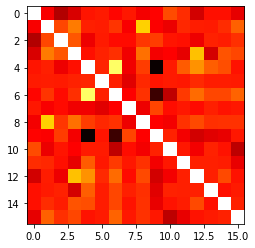

In [6]:
# Pearson Correlation Coefficient
pear_corr = df.corr(method='pearson')
plt.imshow(pear_corr, cmap='hot')
plt.show()

## Train/Test-Split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

print(X_train.shape)
print(X_test.shape)

(4868, 15)
(1218, 15)


# Classification

In [8]:
# store classifiers for later plotting
clf_list = []

## Gaussian Naive Bayes

In [9]:
gaussian_clf = GaussianNB()

# fit the model
gaussian_clf.fit(X_train, y_train)
clf_list.append(gaussian_clf)

pp.print_metrics(gaussian_clf, X_test, y_test)

Weighted accuracy: 0.6232
Weighted f1: 0.6085
Weighted recall: 0.6232
Weighted precision: 0.6541
Contained classes in prediction: {0, 1}
Contained classes in test: {0, 1}


## SVM

In [10]:
svc_clf = SVC()

# fit the model
svc_clf.fit(X_train, y_train)
clf_list.append(svc_clf)

pp.print_metrics(svc_clf, X_test, y_test)

## Neural Network

In [11]:
nn_clf = MLPClassifier()

# fit the model
nn_clf.fit(X_train, y_train)
clf_list.append(nn_clf)

pp.print_metrics(nn_clf, X_test, y_test)

Weighted accuracy: 0.6814
Weighted f1: 0.6809
Weighted recall: 0.6814
Weighted precision: 0.6849
Contained classes in prediction: {0, 1}
Contained classes in test: {0, 1}


c:\Users\Kevin Katzkowski\Documents\projects\song-popularity\venv\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


## K-Neighbours Classifier

In [12]:
knn_clf = KNeighborsClassifier()

# fit the model
knn_clf.fit(X_train, y_train)
clf_list.append(knn_clf)

pp.print_metrics(knn_clf, X_test, y_test)

Weighted accuracy: 0.6338
Weighted f1: 0.6334
Weighted recall: 0.6338
Weighted precision: 0.6365
Contained classes in prediction: {0, 1}
Contained classes in test: {0, 1}


## Decision Trees

In [13]:
dt_clf = DecisionTreeClassifier()

# fit the model
dt_clf.fit(X_train, y_train)
clf_list.append(dt_clf)

pp.print_metrics(dt_clf, X_test, y_test)

Weighted accuracy: 0.5649
Weighted f1: 0.565
Weighted recall: 0.5649
Weighted precision: 0.5652
Contained classes in prediction: {0, 1}
Contained classes in test: {0, 1}


## Random Forest

In [14]:
# use different number of trees in forest 
forest_size = [250]

# set seed for random state to get compareable results in every execution (forest randomness)
np.random.seed(500)

for trees in forest_size:
    # set forest size
    print("Predicting with forest size " + str(trees))
    rf = RandomForestClassifier(n_estimators=trees)

    # fit the model
    rf.fit(X_train, y_train)
    clf_list.append(rf)

    pp.print_metrics(rf, X_test, y_test)
    print("--------\n")

Predicting with forest size 250
Weighted accuracy: 0.6658
Weighted f1: 0.6651
Weighted recall: 0.6658
Weighted precision: 0.6698
Contained classes in prediction: {0, 1}
Contained classes in test: {0, 1}
--------



## Ensemble

In [16]:
from sklearn.ensemble import VotingClassifier, AdaBoostClassifier

# ens_clf = VotingClassifier(estimators=[
#     ('gauss', GaussianNB()), ('knn', KNeighborsClassifier()), ('rf', RandomForestClassifier())
# ])

ens_clf = AdaBoostClassifier(base_estimator=GaussianNB(), 
    n_estimators=25, random_state=42)

ens_clf.fit(X_train, y_train)

pp.print_metrics(ens_clf, X_test, y_test)

Weighted accuracy: 0.5213
Weighted f1: 0.4619
Weighted recall: 0.5213
Weighted precision: 0.558
Contained classes in prediction: {0, 1}
Contained classes in test: {0, 1}


# Model Evaluation

## Store models to .mdl file

In [ ]:
# pp.store_model_to_file(rf, "rf_size=1000_prec=41", "music")

## Metrics + Confusion Matrices

In [17]:
 # generate list of plots for each clf: metrics, cf_matrix, cf_matrix_norm
 p_list = p.generate_model_plots(X_test, y_test, clf_list)

## Save/display plots

In [ ]:
# params
save_plots = False
n_cols = 3
document_title = "Random Forest up to 2000 trees"
document_folder = "all" # lyrics, model, artist, all

# save/display plots as jpg
p.plots_from_list(document_title, p_list, document_folder, cols=n_cols, save=save_plots)

## Feature importance

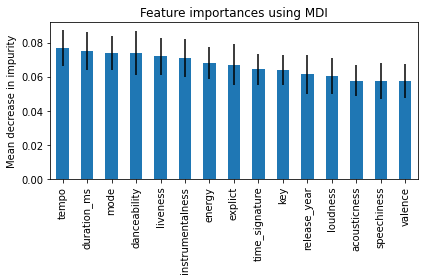

In [18]:
importances = rf.feature_importances_
std = np.std([
    tree.feature_importances_ for tree in rf.estimators_], axis=0)

feature_list = list(map(lambda feat: "loudness" if feat == "loadness" else feat, list(df)[:15]))

forest_importances = pd.Series(importances, index=feature_list).sort_values(ascending=False)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

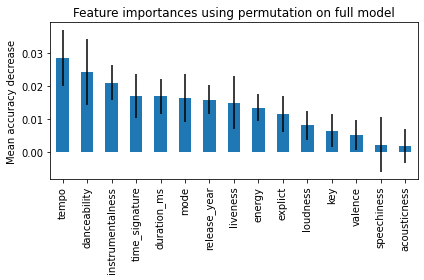

In [19]:
from sklearn.inspection import permutation_importance

result = permutation_importance(
    rf, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2)


feature_list = list(map(lambda feat: "loudness" if feat == "loadness" else feat, list(df)[:15]))

forest_importances = pd.Series(result.importances_mean, index=feature_list).sort_values(ascending=False)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

## Confusion Matrix for Single Classifier

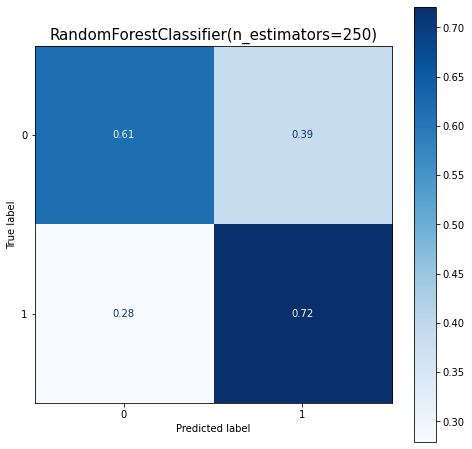

In [20]:
# assign single classifier
cf_clf = rf
normalized = "true" # "true", "all" or None

# Confusion matrix
fig, cax = plt.subplots(figsize=(8, 8)) # subplot for larger size
cax.set_title(str(cf_clf), fontsize=15)
plot_confusion_matrix(estimator=cf_clf, X=X_test, y_true=y_test, cmap=plt.cm.Blues,normalize=normalized,values_format=".2f",ax=cax)

plt.show()